Simple example how to use segmentation in Keras

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm_notebook
import cv2

import keras
from keras.layers import UpSampling2D, Conv2D, Activation
from keras import Model

Using TensorFlow backend.


In [2]:
tr = pd.read_csv('../input/severstal-steel-defect-detection/train.csv')
print(len(tr))
tr.head()

50272


,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [3]:
# Only ClassId=4

df_train = tr[tr['EncodedPixels'].notnull()].reset_index(drop=True)
df_train = df_train[df_train['ImageId_ClassId'].apply(lambda x: x.split('_')[1] == '4')].reset_index(drop=True)
print(len(df_train))
df_train.head()

801


,ImageId_ClassId,EncodedPixels
0,000f6bf48.jpg_4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
1,0025bde0c.jpg_4,315139 8 315395 15 315651 16 315906 17 316162 ...
2,002af848d.jpg_4,290800 6 291055 13 291311 15 291566 18 291822 ...
3,0030401a5.jpg_4,186833 1 187089 3 187344 6 187600 7 187855 10 ...
4,008621629.jpg_4,215548 3 215798 9 216051 12 216306 13 216560 1...


In [4]:
def rle2mask(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

In [5]:
img_size = 256

In [6]:
def keras_generator(batch_size):
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):            
            fn = df_train['ImageId_ClassId'].iloc[i].split('_')[0]
            img = cv2.imread( '../input/severstal-steel-defect-detection/train_images/'+fn )
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)            
            
            mask = rle2mask(df_train['EncodedPixels'].iloc[i], img.shape)
            
            img = cv2.resize(img, (img_size, img_size))
            mask = cv2.resize(mask, (img_size, img_size))
            
            x_batch += [img]
            y_batch += [mask]
                                    
        x_batch = np.array(x_batch)
        y_batch = np.array(y_batch)

        yield x_batch, np.expand_dims(y_batch, -1)

In [7]:
for x, y in keras_generator(4):
    break
    
print(x.shape, y.shape)

(4, 256, 256, 3) (4, 256, 256, 1)


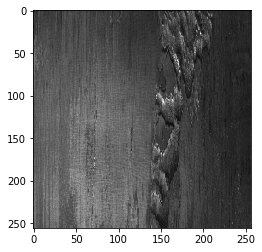

In [8]:
plt.imshow(x[3])

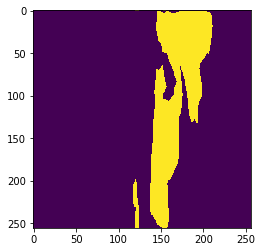

In [9]:
plt.imshow(np.squeeze(y[3]))

In [10]:
from keras.applications.vgg16 import VGG16
base_model = VGG16(weights=None, input_shape=(img_size,img_size,3), include_top=False)
base_model.load_weights('../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [11]:
base_model.trainable = False

In [12]:
base_out = base_model.output
up = UpSampling2D(32, interpolation='bilinear')(base_out)
conv = Conv2D(1, (1, 1))(up)
conv = Activation('sigmoid')(conv)

model = Model(input=base_model.input, output=conv)

model.compile(keras.optimizers.Adam(lr=0.0001), 'binary_crossentropy')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`
  


In [13]:
%%time
batch_size = 16
model.fit_generator(keras_generator(batch_size),
              steps_per_epoch=100,                    
              epochs=5,                    
              verbose=1,
              shuffle=True)

Epoch 1/5
100/100 [==============================] - 35s 349ms/step - loss: 0.1339
Epoch 2/5
100/100 [==============================] - 29s 288ms/step - loss: 0.0688
Epoch 3/5
100/100 [==============================] - 29s 288ms/step - loss: 0.0634
Epoch 4/5
100/100 [==============================] - 29s 288ms/step - loss: 0.0620
Epoch 5/5
100/100 [==============================] - 29s 288ms/step - loss: 0.0615
CPU times: user 2min 21s, sys: 1min 22s, total: 3min 44s
Wall time: 2min 31s


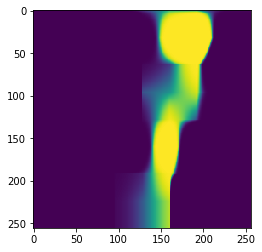

In [14]:
pred = model.predict(x)
plt.imshow(np.squeeze(pred[3]))

In [15]:
testfiles=os.listdir("../input/severstal-steel-defect-detection/test_images/")
len(testfiles)

1801

In [16]:
%%time
test_img = []
for fn in tqdm_notebook(testfiles):
        img = cv2.imread( '../input/severstal-steel-defect-detection/test_images/'+fn )
        img = cv2.resize(img,(img_size,img_size))       
        test_img.append(img)


CPU times: user 8.53 s, sys: 636 ms, total: 9.16 s
Wall time: 11.8 s


In [17]:
%%time
predict = model.predict(np.asarray(test_img))
print(len(predict))

1801
CPU times: user 3.09 s, sys: 9.47 s, total: 12.6 s
Wall time: 11.3 s


In [18]:
def mask2rle(img):
    tmp = np.rot90( np.flipud( img ), k=3 )
    rle = []
    lastColor = 0;
    startpos = 0
    endpos = 0

    tmp = tmp.reshape(-1,1)   
    for i in range( len(tmp) ):
        if (lastColor==0) and tmp[i]>0:
            startpos = i
            lastColor = 1
        elif (lastColor==1)and(tmp[i]==0):
            endpos = i-1
            lastColor = 0
            rle.append( str(startpos)+' '+str(endpos-startpos+1) )
    return " ".join(rle)

In [19]:
%%time
pred_rle = []
for img in predict:      
    img = cv2.resize(img, (1600, 256))
    tmp = np.copy(img)
    tmp[tmp<np.mean(img)] = 0
    tmp[tmp>0] = 1
    pred_rle.append(mask2rle(tmp))

CPU times: user 19min 49s, sys: 0 ns, total: 19min 49s
Wall time: 19min 48s


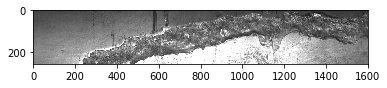

In [20]:
img_t = cv2.imread( '../input/severstal-steel-defect-detection/test_images/'+ testfiles[4])
plt.imshow(img_t)

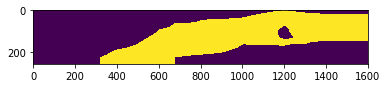

In [21]:
mask_t = rle2mask(pred_rle[4], img.shape)
plt.imshow(mask_t)

In [22]:
sub = pd.read_csv( '../input/severstal-steel-defect-detection/sample_submission.csv', converters={'EncodedPixels': lambda e: ' '} )
sub.head()

,ImageId_ClassId,EncodedPixels
0,004f40c73.jpg_1,
1,004f40c73.jpg_2,
2,004f40c73.jpg_3,
3,004f40c73.jpg_4,
4,006f39c41.jpg_1,


In [23]:
%%time
for fn, rle in zip(testfiles, pred_rle):
    sub['EncodedPixels'][(sub['ImageId_ClassId'].apply(lambda x: x.split('_')[0]) == fn) & \
                        (sub['ImageId_ClassId'].apply(lambda x: x.split('_')[1] == '4'))] = rle

CPU times: user 21.9 s, sys: 804 ms, total: 22.7 s
Wall time: 22.6 s


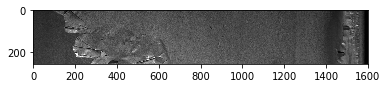

In [24]:
img_s = cv2.imread( '../input/severstal-steel-defect-detection/test_images/'+ sub['ImageId_ClassId'][47].split('_')[0])
plt.imshow(img_s)

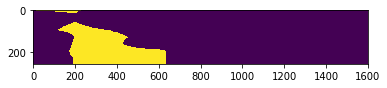

In [25]:
mask_s = rle2mask(sub['EncodedPixels'][47], (256, 1600))
plt.imshow(mask_s)

In [26]:
sub.to_csv('submission.csv', index=False)